Generating Spoof Images and Calculating Image Transfer Functions

In [1]:
#Imports
#from PIL import Image, ImageDraw # Don't use
%matplotlib inline
from matplotlib import pyplot as plt
import skimage
from skimage.viewer import ImageViewer
import numpy as np
import scipy

#Import opencv for faster Gaussians
import cv2
import imutils

#For 3D Plot
from mpl_toolkits import mplot3d


/Users/sanjayankulendran/opt/anaconda3/lib/python3.8/site-packages/skimage/viewer/utils/__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  from .core import *


In [2]:
#Parameters for imager/setup

#Original Image Source (before rotation)
sourceW = 2000 #Image Width
sourceH = 2000 #Image Height

#Rotation frame (the size of the viewing frame such that the image is visible), always square
frameWidth = np.floor((np.minimum([sourceW],[sourceH])/np.sqrt(2)))

#Parameters of 'edges' 
#edgeDC = 0.5 # Duty cycle between dark and light segments
#edgeA = 45 # Angle of edges (lines 'radiate' from this point, repeating pattern)
edgeRange = np.arange(10,1000, 10) #range of edge sizes to try
angleRange = np.arange(0,90,10) #Range of angles to try

#Edges to visualize (step through)
#visualize = [10, 50, 100, 200, 400, 1000]
visualize = [100]
#visualize = [0]

#Empty array that will be written with the contrasts for each edge size
contrasts = np.zeros([len(edgeRange), len(angleRange)])

#Gaussian blur factor
sigma = 100

#Vignetting Factor
vFact = 1

#'sensor' parameters
sensorW = 200
sensorH = 100


Generate 'Original' Image

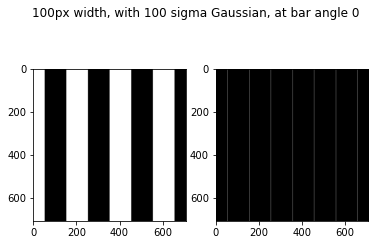

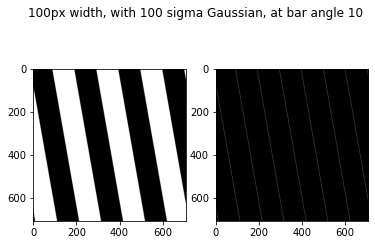

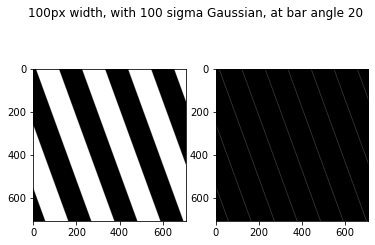

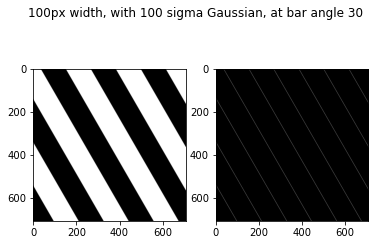

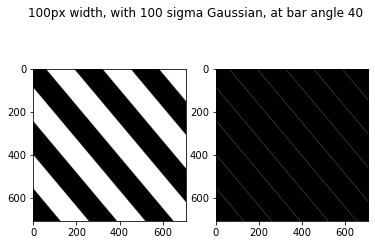

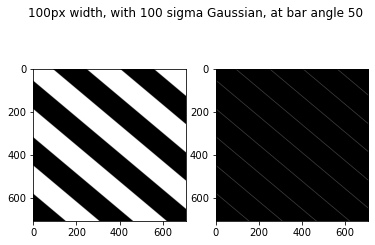

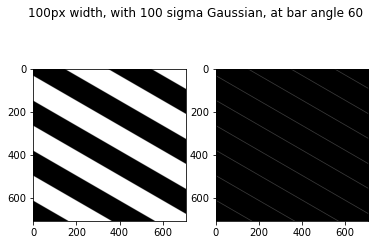

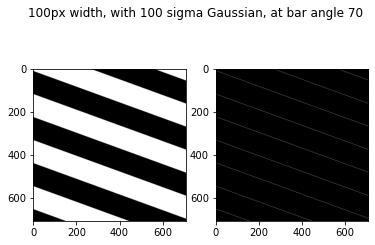

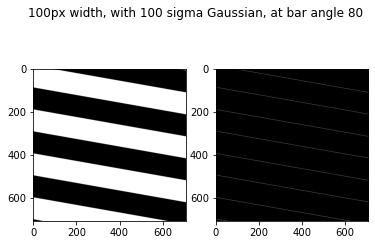

In [3]:
#Parameters for imager/setup

#Original Image Source (before rotation)
sourceW = 2000 #Image Width
sourceH = 2000 #Image Height

#Rotation frame (the size of the viewing frame such that the image is visible), always square
frameWidth = np.floor((np.minimum([sourceW],[sourceH])/np.sqrt(2)))

#Reset index of contrasts array
edgeIndex = 0

#For every image width
#For every spacing requirement
for edgeSize in edgeRange:
    
    #Reset index of angle array
    angleIndex = 0
    
    #For every angle to try
    for edgeAngle in angleRange:

        #Intitate blank array with original image dims
        sourceImage = np.zeros((sourceH, sourceW), dtype=np.uint8)

        #For every line required
        for lineNumber in range(0, (sourceW + 2*edgeSize), 2*edgeSize):

            #Convert the corresponding parts of the array into white
            sourceImage[:,lineNumber:(min((lineNumber+edgeSize),(sourceW-1)))] = 255

        #Apply the rotation step
        rotated = imutils.rotate(sourceImage, edgeAngle)
        #Crop to rotation frame
        rotatedCrop = rotated[int(sourceH/2-frameWidth/2):int(sourceH/2+frameWidth/2), int(sourceW/2-frameWidth/2):int(sourceW/2+frameWidth/2)]
        
        #edge detection filter
        kernel = np.array([[0.0, -1.0, 0.0], 
                   [-1.0, 4.0, -1.0],
                   [0.0, -1.0, 0.0]])

        kernel = kernel/(np.sum(kernel) if np.sum(kernel)!=0 else 1)
        
        highPass = cv2.filter2D(rotatedCrop,-1,kernel)

        #Apply a Gaussian blur, using cv2 now for better performance
        #blurred = skimage.filters.gaussian(sourceImage, sigma=(sigma, sigma),  multichannel=False, preserve_range=True)
        #blurred = cv2.GaussianBlur(rotatedCrop, [0,0], sigma, sigma,  cv2.BORDER_DEFAULT)
        
        #Subtracting the blurred sample from the original sample creates an effective high-pass filter
        #blurredHP = rotatedCrop - blurred

        #Sample from interior to avoid edge effects
        blurredSample = highPass[int(frameWidth/4):int(3*frameWidth/4),int(frameWidth/4):int(3*frameWidth/4)]
        
        #print(str(edgeIndex) + ' e:a ' + str(angleIndex))
        
        #Record the difference between the minimum and maximum values in the image
        contrasts[edgeIndex,angleIndex] = blurredSample.max() - blurredSample.min()

        #If this is a step to visualize
        if edgeSize in visualize:

            #Set up subplots
            fig, (ax1, ax2) = plt.subplots(1,2)
            fig.suptitle(str(edgeSize) + 'px width, with '+str(sigma) + ' sigma Gaussian, at bar angle ' + str(edgeAngle))

            #Display the image
            ax1.imshow(rotatedCrop[int(frameWidth/4):int(3*frameWidth/4),int(frameWidth/4):int(3*frameWidth/4)].astype(np.uint8), cmap='gray', vmin=0, vmax=255)
            ax2.imshow(blurredSample.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
            
            #Save the image
            #fig.savefig('./static/image.jpg')

            #Display the blur
            #plt.imshow(blurredSample.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
            #plt.title(str(edgeSize) + 'px Width, with '+str(sigma) +' sigma Gaussian')
            #plt.show()
        
        #Increment the angle index
        angleIndex += 1

    #Increment Contrasts Array
    edgeIndex += 1


In [4]:
edgeRange

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520,
       530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650,
       660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780,
       790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910,
       920, 930, 940, 950, 960, 970, 980, 990])

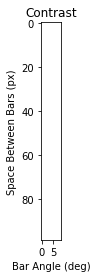

In [5]:
#print(blurred[int(sourceH/4):int(3*sourceH/4),int(sourceW/4):int(3*sourceW/4)])

#Display the crop data as an image
plt.imshow(contrasts.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
plt.title('Contrast')
plt.xlabel("Bar Angle (deg)")
plt.ylabel("Space Between Bars (px)")
plt.show()


/var/folders/sj/sxjb182939xffckhc9376clc0000gn/T/ipykernel_20370/4029431350.py:26: UserWarning: No contour levels were found within the data range.
  ax.contour3D(x1, y1, contrasts, 50, colvar = contrasts)
/var/folders/sj/sxjb182939xffckhc9376clc0000gn/T/ipykernel_20370/4029431350.py:26: UserWarning: The following kwargs were not used by contour: 'colvar'
  ax.contour3D(x1, y1, contrasts, 50, colvar = contrasts)


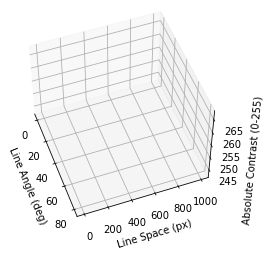

In [6]:
#Convert the contrasts[edgeIndex,angleIndex] data to a 3D set of points
#Z set is the flattened contrasts array
Z = contrasts.flatten()
#X axis is the same as the edges to check, but expanded by the amount of angles
X = []
Y = []

#For every element in length of Z
for i in range(0,len(Z)):
    
    #The corresponding X value is the integer division of i/(angles)
    X.append(i//len(angleRange))
    
    #The corresponding Y value is the integer division remainder (modulo) of i/(angles)
    Y.append(i%len(angleRange))

#For every element in 
x1, y1 = np.meshgrid(angleRange, edgeRange)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('Line Angle (deg)')
ax.set_ylabel('Line Space (px)')
ax.set_zlabel('Absolute Contrast (0-255)')
ax.view_init(50, -20)
ax.contour3D(x1, y1, contrasts, 50, colvar = contrasts)

In [7]:
#Get average statistics 
print("Mean Contrast " + str(np.mean(contrasts)) + ", At " + str(sigma) + " Sigma Blur")
print("Median Contrast " + str(np.median(contrasts,axis=None)))
print("Mode Contrast " + str(scipy.stats.mode(contrasts,axis=None)))

Mean Contrast 255.0, At 100 Sigma Blur
Median Contrast 255.0
Mode Contrast ModeResult(mode=array([255.]), count=array([891]))


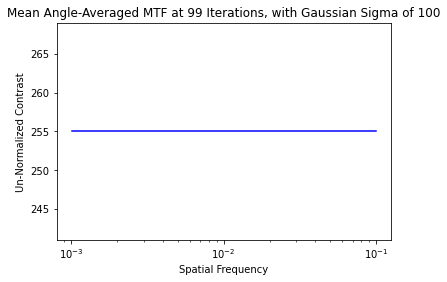

In [8]:
#Plot the MTF average
#Mean MTF
meanMTF = np.mean(contrasts, axis=1)
#Plot
plt.plot(np.flip(np.reciprocal(edgeRange.astype(float))),np.flip(meanMTF),linestyle='solid',color='blue')
plt.title("Mean Angle-Averaged MTF at " + str(len(edgeRange)) + " Iterations, with Gaussian Sigma of " + str(sigma))
plt.xscale("log")
plt.xlabel("Spatial Frequency")
plt.ylabel("Un-Normalized Contrast")
plt.show()
